In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Step 1: Data Preprocessing and Cleaning
def preprocess_data(filepath):
    print("Reading data from:", filepath)
    data = pd.read_csv(filepath)
    print("Initial data shape:", data.shape)

    data = data.drop(columns=["User ID", "Unnamed: 10", "Unnamed: 11", "Unnamed: 12"], errors='ignore')
    print("Data shape after dropping unnecessary columns:", data.shape)

    mapping = {
        "Mandala Design Pattern": {"1 (Complex)": 1, "2 (Medium)": 2, "3 (Simple)": 3},
        "Gender": {"Male": 0, "Female": 1, "Other": 2}
    }
    data.replace(mapping, inplace=True)
    print("Data after applying mappings:")
    print(data.head())

    # Encode target labels
    le = LabelEncoder()
    data["Stress Level (1-4)"] = le.fit_transform(data["Stress Level (1-4)"])
    print("Data after encoding target labels:")
    print(data.head())
    return data, le

In [10]:
# Load and preprocess the data
file_path = '/content/drive/MyDrive/dataset.csv'
data, label_encoder = preprocess_data(file_path)

Reading data from: /content/drive/MyDrive/dataset.csv
Initial data shape: (1009, 13)
Data shape after dropping unnecessary columns: (1009, 9)
Data after applying mappings:
   Age  Gender  Mandala Design Pattern  Mandala Colors Used  \
0   25       0                       1                    4   
1   30       1                       3                    7   
2   28       0                       2                    6   
3   35       0                       1                    3   
4   22       1                       2                    5   

   Mandala Time Spent (mins)  Music Type  Music Time Spent (mins)  \
0                         20           8                       30   
1                         15           5                       25   
2                         10           4                       20   
3                         25           6                       20   
4                         35           4                       15   

   Total Time (mins)  Stress Level

In [11]:
# Split features and target
X = data.drop(columns=["Stress Level (1-4)"])
y = to_categorical(data["Stress Level (1-4)"])

In [12]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Feature data after scaling:")
print(X_scaled[:5])

Feature data after scaling:
[[-1.55218581 -1.08235514 -1.21991483 -0.61281349 -0.98676985  1.77639502
   1.48242801  0.34121513]
 [ 0.13475461  0.87480675  1.23451003  0.89408045 -1.75561215 -0.28856186
   0.61631923 -1.32602973]
 [-0.54002156 -1.08235514  0.0072976   0.39178247 -2.52445445 -0.97688082
  -0.24978955 -2.99327458]
 [ 1.82169502 -1.08235514 -1.21991483 -1.11511147 -0.21792755  0.3997571
  -0.24978955 -0.4924073 ]
 [-2.56435006  0.87480675  0.0072976  -0.11051551  1.31975705 -0.97688082
  -1.11589833  0.34121513]]


In [13]:
# Reshape data for RNN input
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
print("Data shape after reshaping for RNN:", X_reshaped.shape)

Data shape after reshaping for RNN: (1009, 8, 1)


In [14]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (807, 8, 1)
Testing data shape: (202, 8, 1)


In [15]:
# Step 2: Selecting the Right Machine Learning Model (RNN Model)
print("Building the RNN model...")
model = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

Building the RNN model...


In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Model summary:")
model.summary()

Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 8, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,180 (461.64 KB)

 Trainable params: 118,180 (461.64 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Step 3: Training Machine Learning Model
print("Starting training...")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
print("Training complete.")

Starting training...
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2823 - loss: 1.3706 - val_accuracy: 0.3519 - val_loss: 1.2505
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4137 - loss: 1.2376 - val_accuracy: 0.3765 - val_loss: 1.2152
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4176 - loss: 1.2013 - val_accuracy: 0.4074 - val_loss: 1.1625
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4328 - loss: 1.1448 - val_accuracy: 0.4691 - val_loss: 1.0989
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4912 - loss: 1.0738 - val_accuracy: 0.5432 - val_loss: 1.0342
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5261 - loss: 1.0051 - val_accuracy: 0.5617 - val_loss: 1.0396
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.4919 - loss: 1.0253 - val_accuracy: 0.5185 - val_loss: 0.9981
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5544 - loss: 0.9889 - val

In [18]:
# Step 4: Evaluating Model Performance
print("Evaluating the model...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Evaluating the model...
Test Loss: 0.8097589612007141, Test Accuracy: 0.6683168411254883


In [19]:
# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Confusion Matrix:
[[33 15  3  1]
 [ 7 36 16  0]
 [ 7  9 31  2]
 [ 7  0  0 35]]


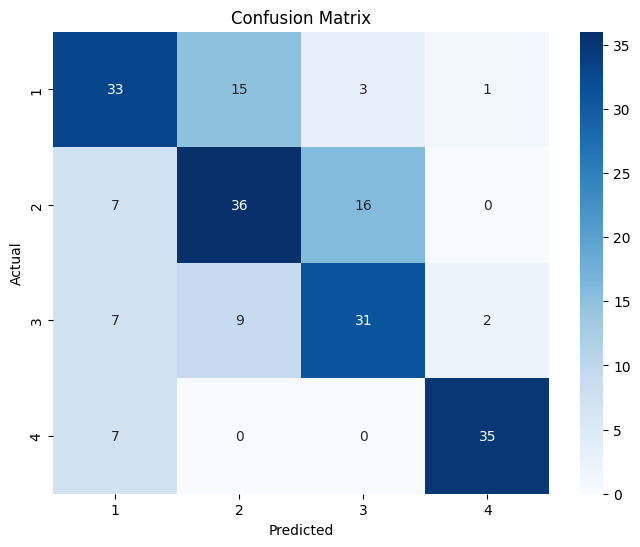

In [20]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))


Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.63      0.62        52
           1       0.60      0.61      0.61        59
           2       0.62      0.63      0.63        49
           3       0.92      0.83      0.88        42

    accuracy                           0.67       202
   macro avg       0.69      0.68      0.68       202
weighted avg       0.67      0.67      0.67       202



In [24]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.7 MB/s eta 0:00:00


In [25]:
# Step 5: Tuning and Optimizing Model
print("Starting hyperparameter tuning...")
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential([
        LSTM(hp.Int('units_1', min_value=64, max_value=256, step=32), activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)),
        LSTM(hp.Int('units_2', min_value=32, max_value=128, step=32), activation='tanh'),
        Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu'),
        Dense(y.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='stress_rnn_tuning'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
print("Hyperparameter search complete.")

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(best_hps.values)

best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
print("Best model training complete.")

Trial 5 Complete [00h 00m 19s]
val_accuracy: 0.5864197611808777

Best val_accuracy So Far: 0.5987654328346252
Total elapsed time: 00h 01m 46s
Hyperparameter search complete.
Best hyperparameters:
{'units_1': 192, 'dropout_1': 0.2, 'units_2': 64, 'dropout_2': 0.2, 'dense_units': 64}
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.3136 - loss: 1.3608 - val_accuracy: 0.3457 - val_loss: 1.2711
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4211 - loss: 1.2299 - val_accuracy: 0.4506 - val_loss: 1.1596
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4652 - loss: 1.1416 - val_accuracy: 0.5000 - val_loss: 1.1025
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5239 - loss: 1.0553 - val_accuracy: 0.4877 - val_loss: 1.0392
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5426 - loss: 0.9910 - val_accuracy: 0.5432 - val_loss: 1.0480
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5466 - loss: 0.98

In [22]:
# Step 6: Deploying the Model and Making Predictions
best_model.save('/content/drive/MyDrive/Models/stress_detection_rnn_model.h5')
print("Model saved to stress_detection_rnn_model.h5")

Model saved to stress_detection_rnn_model.h5
